## ***Libraries***

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from collections import Counter
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel
import joblib

## ***Data***

In [2]:
data = pd.read_excel("Raw Data.xlsx")
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


## ***Summary Statistics***

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [ ]:
data.isna().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(data)
print(f"\n{colored('Numerical Columns:','blue', attrs=['reverse'])} {num_cols}\n\n\n{colored('Categorical Columns:','magenta', attrs=['reverse'])} {cat_cols}\n\n\n"
        f"{colored('Cardinal Columns:','cyan', attrs=['reverse'])}{cat_but_car}\n")

Observations: 43400
Variables: 12
cat_cols: 8
num_cols: 4
cat_but_car: 0
num_but_cat: 3

Numerical Columns: ['id', 'age', 'avg_glucose_level', 'bmi']


Categorical Columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease', 'stroke']


Cardinal Columns:[]



In [ ]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


## ***Data Cleaning***

In [3]:
data['age'] = data['age'].astype(int)

In [4]:
data = data.copy()
data = data[data['age']>=18]

In [5]:
data.isnull().sum()

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                  1350
smoking_status       7174
stroke                  0
dtype: int64

In [6]:
data['bmi'].fillna(data['bmi'].median(),inplace=True)

In [7]:
data['smoking_status'].fillna(data['smoking_status'].mode()[0],inplace=True)

In [ ]:
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [8]:
data = data[data['gender'] != 'Other']

## ***Correlation***

Point Biserial Correlation with Target Variable (Numerical Predictors):
age: 0.16
hypertension: 0.07
heart_disease: 0.11
avg_glucose_level: 0.07
bmi: -0.01

Cramér's V with Target Variable (Categorical Predictors):
gender: Cramér's V = 0.02
ever_married: Cramér's V = 0.04
work_type: Cramér's V = 0.05
Residence_type: Cramér's V = 0.00
smoking_status: Cramér's V = 0.03

Combined Correlations with Target Variable:
age: 0.16
hypertension: 0.07
heart_disease: 0.11
avg_glucose_level: 0.07
bmi: -0.01
gender: 0.02
ever_married: 0.04
work_type: 0.05
Residence_type: 0.00
smoking_status: 0.03


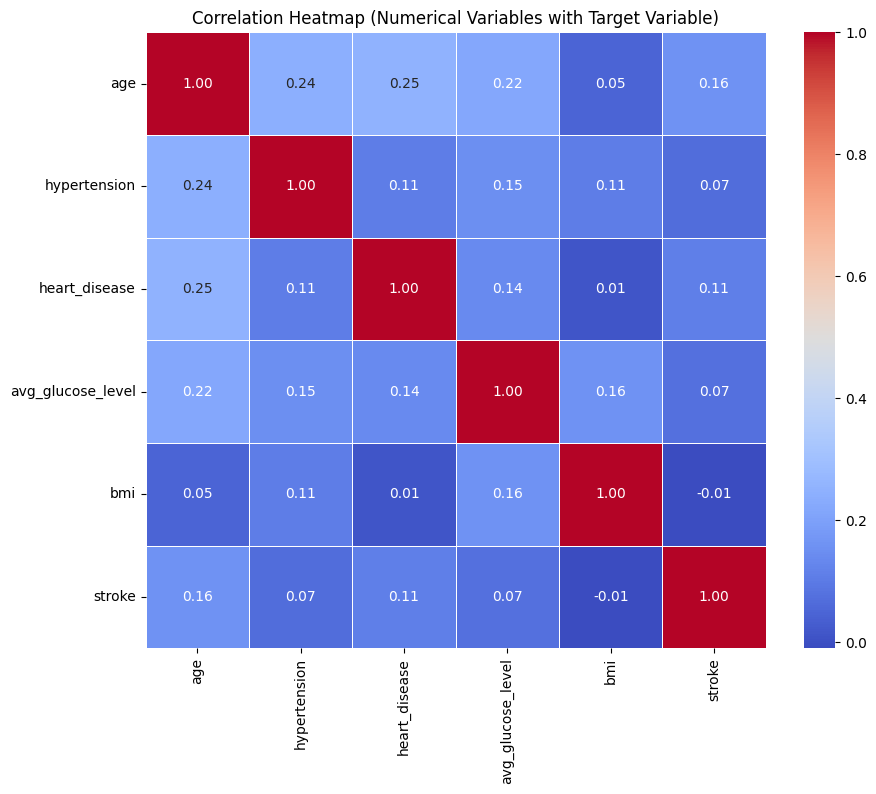

In [ ]:
numerical_predictors = ['age','hypertension','heart_disease','avg_glucose_level','bmi']
categorical_predictors = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

point_biserial_correlation = {}
for column in numerical_predictors:
    correlation, _ = stats.pointbiserialr(data[column], data['stroke'])
    point_biserial_correlation[column] = correlation

# Function to calculate Cramér's V
def cramers_v(contingency_table):
    chi2 = stats.chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Calculate chi-square statistic and Cramér's V for categorical predictors
chi2_stats = {}
cramers_v_values = {}
for column in categorical_predictors:
    contingency_table = pd.crosstab(data[column], data['stroke'])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    chi2_stats[column] = chi2
    cramers_v_values[column] = cramers_v(contingency_table)

# Display the point biserial correlations for numerical predictors
print("Point Biserial Correlation with Target Variable (Numerical Predictors):")
for predictor, correlation in point_biserial_correlation.items():
    print(f"{predictor}: {correlation:.2f}")

# Display the chi-square statistics and Cramér's V for categorical predictors
print("\nCramér's V with Target Variable (Categorical Predictors):")
for predictor, cramers_v_value in cramers_v_values.items():
    print(f"{predictor}: Cramér's V = {cramers_v_value:.2f}")

# Combine numerical and categorical predictors for a summary
combined_correlations = {**point_biserial_correlation, **cramers_v_values}

# Display the combined correlations
print("\nCombined Correlations with Target Variable:")
for predictor, correlation in combined_correlations.items():
    print(f"{predictor}: {correlation:.2f}")

# If desired, create a heatmap of the correlations of numeric predictors with the target variable
numerical_data = data[numerical_predictors + ['stroke']]  # Include the target variable
correlation_matrix = numerical_data.corr()

# Create a heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Numerical Variables with Target Variable)')
plt.show()
correlation_df = pd.DataFrame(list(combined_correlations.items()), columns=['Variable', 'Correlation'])
correlation_df.set_index('Variable', inplace=True)

## ***Data Preprocessing***

### **Feature Engineering**

In [9]:
# Categorizing Functions

# Average Glucose Level Categoization
def classify_glucose_level(glucose_level):
    if 80 <= glucose_level <= 100:
        return 1  # Normal
    elif 101 <= glucose_level <= 125:
        return 2  # Above Normal
    elif glucose_level >= 126:
        return 3  # Well Above Normal
    else:
        return 0  # Value below normal range

# Age Categoization
def categorize_age(df, age_column, bins, labels):
  if age_column not in df.columns:
        raise ValueError(f"The column '{age_column}' does not exist in the DataFrame.")

    # Use pd.cut to categorize ages
  df['age_category'] = pd.cut(df[age_column], bins=bins, labels=labels,right=False, include_lowest=True)

  return df

# BMI Categoization
def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal weight"
    elif 25 <=bmi< 30:
        return "Overweight"
    elif bmi>=30:
      return "Obese"

In [10]:
data['glucose_level'] = data['avg_glucose_level'].apply(classify_glucose_level)

In [11]:
bins = [18, 30, 40, 50,60,70,80,101]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69','70-79','80-100']
data = categorize_age(data, 'age', bins, labels)

In [12]:
# Assuming 'df' is your DataFrame and 'bmi_column' is the column containing BMI values
data['BMI_Category'] = data['bmi'].apply(categorize_bmi)

In [13]:
data.drop(columns=['bmi','age','id','avg_glucose_level'],axis=1,inplace = True)

### **Encoding** (before feature extraction)

In [14]:
categorical_columns = ['BMI_Category','age_category','gender','smoking_status','ever_married','Residence_type','work_type']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(data[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

data.reset_index(drop=True, inplace=True)
one_hot_df.reset_index(drop=True, inplace=True)

data_encoded = pd.concat([data, one_hot_df], axis=1)
data_encoded = data_encoded.drop(categorical_columns, axis=1)

data_encoded

,hypertension,heart_disease,stroke,glucose_level,BMI_Category_Normal weight,BMI_Category_Obese,BMI_Category_Overweight,BMI_Category_Underweight,age_category_18-29,age_category_30-39,...,smoking_status_never smoked,smoking_status_smokes,ever_married_No,ever_married_Yes,Residence_type_Rural,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed
0,1,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,3,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0,1,0,3,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35845,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
35846,0,0,0,3,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
35847,1,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
35848,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


### **Data Splitting** (before feature extraction)

In [15]:
X = data_encoded.drop('stroke', axis=1)
y = data_encoded['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## ***Feature Extraction***

In [20]:
# Select top k features based on mutual information
k = 3  # Number of features to select
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X_train, y_train)

# Transform the dataset to include only the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_feature_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_feature_indices]  # Assuming X_train is a DataFrame
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['heart_disease', 'age_category_70-79', 'smoking_status_never smoked'], dtype='object')


### Removing unwanted features after feature extraction

In [21]:
data.drop(columns = ['ever_married','Residence_type','work_type'],axis=1,inplace=True)

### **Encoding** (after feature extraction)

In [23]:
categorical_columns = ['BMI_Category','age_category','gender','smoking_status']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(data[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

data.reset_index(drop=True, inplace=True)
one_hot_df.reset_index(drop=True, inplace=True)

data_encoded = pd.concat([data, one_hot_df], axis=1)
data_encoded = data_encoded.drop(categorical_columns, axis=1)


## ***Model Training***

### **Data Splitting** (after feature extraction)

In [24]:
X = data_encoded.drop('stroke', axis=1)
y = data_encoded['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### **Random Oversampling**

In [25]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 35069), (1, 35069)]


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

### **Models**

In [27]:
classifiers = {
    'KNN':KNeighborsClassifier(2),
    'SVC':SVC(gamma=2, C=1, random_state=42),
    'Decision Tree':DecisionTreeClassifier(max_depth=6, random_state=42),
    'Random Forest':RandomForestClassifier(
        max_depth=5, n_estimators=6, max_features=1, random_state=42
    ),
    'AdaBoost':AdaBoostClassifier(algorithm="SAMME", random_state=42),
    'Gradient Boosting':GradientBoostingClassifier(n_estimators=300, learning_rate=0.35, max_depth=11),
    'XGBoost':xgb.XGBClassifier(n_estimators=250, learning_rate=0.47, max_depth=9)
}

In [28]:
model = ""
best_acc = 0
for name,clf in classifiers.items():
  model = clf
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(f"{name} classification report:\n{classification_report(y_test,y_pred)}\n------------------------")
  if(accuracy_score(y_test,y_pred) > best_acc):
    best_acc = accuracy_score(y_test,y_pred)
    model = clf

KNN classification report:
              precision    recall  f1-score   support

           0       0.68      0.86      0.76     11579
           1       0.81      0.60      0.69     11567

    accuracy                           0.73     23146
   macro avg       0.75      0.73      0.73     23146
weighted avg       0.75      0.73      0.73     23146

------------------------
SVC classification report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82     11579
           1       0.79      0.88      0.84     11567

    accuracy                           0.83     23146
   macro avg       0.83      0.83      0.83     23146
weighted avg       0.83      0.83      0.83     23146

------------------------
Decision Tree classification report:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     11579
           1       0.73      0.82      0.77     11567

    accuracy                           0.

In [ ]:
model = SVC(gamma=2, C=1, random_state=42)

In [ ]:
joblib.dump(model, 'brainstrokemodel.pkl')

['brainstrokemodel.pkl']

In [ ]:
joblib.dump(encoder,'brainstrokeEncoder.pkl')

['brainstrokeEncoder.pkl']